<a href="https://colab.research.google.com/github/rhiats/mimicIII/blob/main/Analysis_of_Patients_with_Type_2_Diabetes_in_ICU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Stratification Analysis of Patients with Type 2 Diabetes in ICU**

Person diagnosed with Diabetes.

Type 2 Diabetic ICD9 Codes (250)/ Admissions - 'diabet...'.

- Admissions- breakdown of insurance type. (one hot encode)
- Admissions - gender (one hot encode)
- Prescriptions  - Top 3 drugs (one hot encode)
- Prescriptions - Distribtuion number of drugs per patient
- ICUSTAYS - Distribution of time in ICU
- Open (DIAGNOSES_ICD.csv.gz)

http://www.icd9data.com/2014/Volume1/240-279/249-259/250/250.00.htm

https://physionet.org/content/mimic3-carevue/1.4/

https://machinelearningmastery.com/why-one-hot-encode-data-in-machine-learning/

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df_admissions=pd.read_csv('/content/drive/MyDrive/mimic-iii-clinical-database-carevue-subset-1.4/ADMISSIONS.csv.gz', compression='gzip')
df_patients=pd.read_csv('/content/drive/MyDrive/mimic-iii-clinical-database-carevue-subset-1.4/PATIENTS.csv.gz', compression='gzip')
df_presciptions=pd.read_csv('/content/drive/MyDrive/mimic-iii-clinical-database-carevue-subset-1.4/PRESCRIPTIONS.csv.gz', compression='gzip')

<ipython-input-2-8f50def5d0b2>:3: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  df_presciptions=pd.read_csv('/content/drive/MyDrive/mimic-iii-clinical-database-carevue-subset-1.4/PRESCRIPTIONS.csv.gz', compression='gzip')


**Identify Diabetic Patients**

In [3]:
def diabetetesFind(x):
  """
    Find patients diagnosed with Diabetes.
    @p: pandas series 'diagnosis'
    @r: dataframe with diabetic patients
  """
  x=str(x)
  x=x.lower()
  return x

df_admissions['diagnosis_lower']=df_admissions['diagnosis'].apply(diabetetesFind)
df_diab=df_admissions[df_admissions['diagnosis_lower'].str.contains(pat = 'diabet')]

num_patients=df_diab['subject_id'].nunique()
'There are {} patients in the ICU diagnosed diabetes.'.format(num_patients)

'There are 131 patients in the ICU diagnosed diabetes.'

**Distribution of Patients Gender**

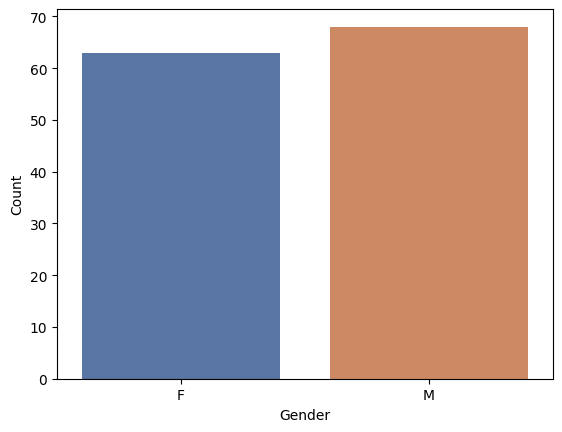

In [4]:
sub_id_diab=list(set(df_diab['subject_id'].to_list()))

df_gender=df_patients[df_patients['subject_id'].isin(sub_id_diab)][['subject_id','gender']]

fem_mal_df=df_gender.groupby(['gender']).count().reset_index()

fem_mal_df.rename(columns={"subject_id": "Count","gender": "Gender"}, inplace=True)

sns.barplot(data=fem_mal_df, x='Gender', y="Count", palette="deep")

plt.savefig("/content/drive/MyDrive/output/gender.png")

**Distribution of Insurance Types for Diabetic Patients**

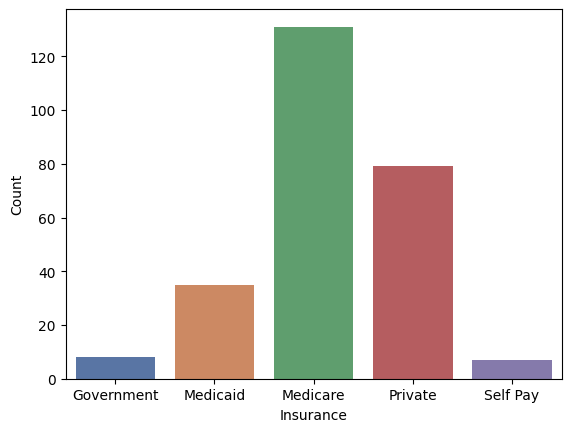

In [5]:
df_insur_diab=df_admissions[df_admissions['subject_id'].isin(sub_id_diab)][['subject_id','insurance']]

insur_df_cnt=df_insur_diab.groupby(['insurance']).count().reset_index()

insur_df_cnt.rename(columns={"subject_id": "Count","insurance": "Insurance"}, inplace=True)

sns.barplot(data=insur_df_cnt, x='Insurance', y="Count", palette="deep")

plt.savefig("/content/drive/MyDrive/output/insurance.png")

**Top 3 Drugs used by Diabetic Patients in the ICU**

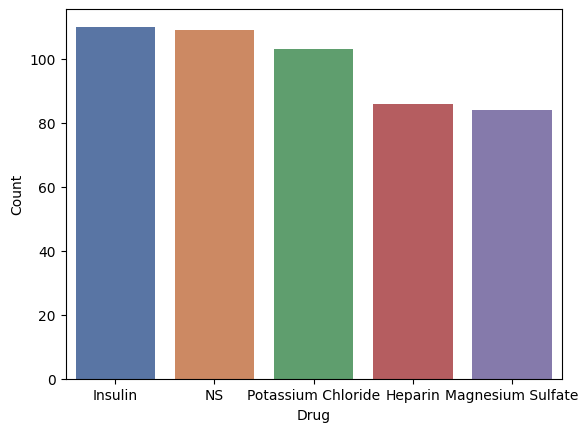

In [6]:
df_drug_diab=df_presciptions[df_presciptions['subject_id'].isin(sub_id_diab)][['subject_id','drug']]
df_drug=df_drug_diab.groupby(['drug']).nunique().reset_index()
df_drug.rename(columns={"subject_id": "Count","drug": "Drug"}, inplace=True)
df_top_5_drugs=df_drug.nlargest(5, 'Count')

sns.barplot(data=df_top_5_drugs, x='Drug', y="Count", palette="deep")

plt.savefig("/content/drive/MyDrive/output/top5Drugs.png")

**PCA**

**Scree Plot**

Select Feature 1

**Interpret the Weights of the First Component**

**Project each patient on the First Component to Calculate their Severity Score**

In the future, patients can be projected on the component to determine their risk for developing Diabetes based on pre-existing conditions. Also, patients who are considered diabetic may be identified from a drug basket.